# Coursework IDA

## Task 1

## 1.1. 
Implement and train a method for automatically classifying texts in the FiQA sentiment analysis
dataset as positive, neutral or negative. Refer to the labs, lecture materials and textbook to identify
a suitable method. In your report:
• Briefly explain how your chosen method works and its main strengths and limitations;
• Describe the preprocessing steps and the features you use to represent each text instance;
• Explain why you chose those features and preprocessing steps and hypothesise how they
will affect your results;
• Briefly describe your software implementation.
(10 marks)



In [8]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
import pandas as pd
import numpy as np
import json

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

# pre trained analyser for comparison
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

# for negation
import re


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# nltk.download('punkt')

In [10]:
train_files = [
    'data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data_cache/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [11]:


def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    # iterate through each tweet file
    for file in json_files:
        # open file in read mode, with method closes file after getting data stream
        with open(file, 'r', encoding = 'utf8') as handle:
            # load file object and convert into json object
            dataf = json.load(handle)
        
        
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.25:
            labels.append(0)
        elif score > 0.32:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 283
Number of neutral labels: 359
Number of positive labels: 469


In [12]:
print(all_labels[0])

0


In [13]:
type(load_fiqa_sa_from_json(train_files))

tuple

In [14]:
print(len(load_fiqa_sa_from_json(train_files)[0]))

1111


In [15]:

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [16]:
print(f'What does one instance look like from the training set? \n\n{train_documents[233]}')
print(f'...and here is its corresponding label \n\n{train_labels[233]}')

What does one instance look like from the training set? 

$CSX is up today to report.  Wall Street is expecting EPS to be at $0.37, and revenues at $2,732B.
...and here is its corresponding label 

2


In [17]:


# CountVectorizer can do its own tokenization, but for consistency we want to
# carry on using WordNetTokenizer. We write a small wrapper class to enable this:
class Tokenizer(object):
    def __call__(self, tweets):
        return word_tokenize(tweets)

    
# create stopwords function from nltk
stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer(tokenizer=Tokenizer())  # construct the vectorizer
# with stop word removal
#vectorizer = CountVectorizer(tokenizer=Tokenizer(), stop_words=stop_words)  # construct the vectorizer

vectorizer.fit(train_documents)  # Learn the vocabulary
X_train = vectorizer.transform(train_documents)  # extract training set bags of words
X_val = vectorizer.transform(val_documents)  # extract test set bags of words
X_test = vectorizer.transform(test_documents)  # extract test set bags of words

C:\Users\loz\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [18]:
# print(nltk.data.path)

In [19]:
# see count vector from training set
counts = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())

In [20]:
X_train

<754x3314 sparse matrix of type '<class 'numpy.int64'>'
	with 10449 stored elements in Compressed Sparse Row format>

In [21]:
counts.columns


Index(['!', '#', '$', '%', '&', ''', '''', ''15', ''breached', ''challenging',
       ...
       'â£22', 'â£250m', 'â£30m', 'â£347', 'â£90m', 'â€', '’', '“', '”', '📈'],
      dtype='object', length=3314)

## Naive Bayes Classifier

In [22]:
# WRITE YOUR CODE HERE
classifier = MultinomialNB()
classifier.fit(X_train, train_labels)

MultinomialNB()

In [23]:
y_val_pred = classifier.predict(X_val)

In [24]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


In [25]:
# Define class labels
classes = ['0', '1', '2']


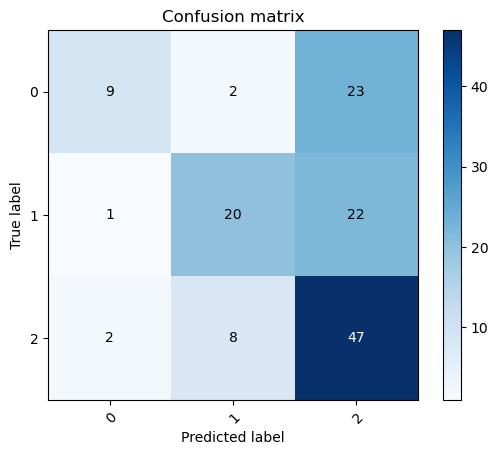

In [26]:
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

In [27]:
# WRITE YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

Accuracy = 0.5671641791044776
Precision (macro average) = 0.642512077294686
Recall (macro average) = 0.5181278549771602
F1 score (macro average) = 0.5233740121756719
              precision    recall  f1-score   support

           0       0.75      0.26      0.39        34
           1       0.67      0.47      0.55        43
           2       0.51      0.82      0.63        57

    accuracy                           0.57       134
   macro avg       0.64      0.52      0.52       134
weighted avg       0.62      0.57      0.54       134



In [28]:
vocabulary = vectorizer.vocabulary_

### CHANGE THE NAME OF THE CLASSIFIER VARIABLE BELOW TO USE YOUR TRAINED CLASSIFIER
feat_likelihoods = np.exp(classifier.feature_log_prob_)  # Use exponential to convert the logs back to probabilities
###

# WRITE YOUR CODE HERE
print(feat_likelihoods[:, vocabulary['a']])
print(feat_likelihoods[:, vocabulary['it']])

[0.0043881  0.00523713 0.00751787]
[0.00308792 0.00349142 0.00184866]


# Logistic Regression Classifier



In [29]:


classifier = LogisticRegression()
classifier.fit(X_train, train_labels)

LogisticRegression()

In [30]:
y_val_pred = classifier.predict(X_val)

In [31]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


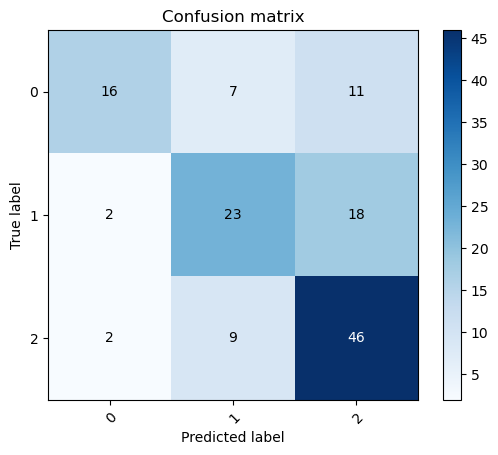

In [32]:

# Define class labels
classes = ['0', '1', '2']

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

## 1.2. Evaluate Method

Evaluate your method, then interpret and discuss your results. Include the following points:
• Define your performance metrics and state their limitations;
• Describe the testing procedure (e.g., how you used each split of the dataset);
• Show your results using suitable plots or tables;
• How could you improve the method or experimental process? Consider the errors that your
method makes.  
(9 marks)


In [33]:
# WRITE YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

Accuracy = 0.6343283582089553
Precision (macro average) = 0.6676923076923077
Recall (macro average) = 0.6041631666946664
F1 score (macro average) = 0.6168459664394624
              precision    recall  f1-score   support

           0       0.80      0.47      0.59        34
           1       0.59      0.53      0.56        43
           2       0.61      0.81      0.70        57

    accuracy                           0.63       134
   macro avg       0.67      0.60      0.62       134
weighted avg       0.65      0.63      0.63       134



## With Data Processing

In [34]:
def add_negation(sentence):
    # define regex pattern to match words after "not", "n't", or "never"
    pattern = r"(?:(?:(?:not)|(?:n't)|(?:never))\s+)(\w+)"
    
    # use regex to find and replace words with negation prefix
    result = re.sub(pattern, r" not_\1", sentence)
    
    return result

In [35]:
# apply add_negation to each tweet in the array using a list comprehension
all_text_negated = np.array([add_negation(text) for text in all_text])


In [36]:
# convert all tweets to lower case
all_text_negated = np.char.lower(all_text_negated)

In [37]:

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text_negated, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [38]:
print(f'What does one instance look like from the training set? \n\n{train_documents[233]}')
print(f'...and here is its corresponding label \n\n{train_labels[233]}')

What does one instance look like from the training set? 

$tsla you have to love these types of articles. ss interest rose on 12/15 on day before we hit our lows. http://stks.co/c1qkr
...and here is its corresponding label 

0


In [39]:


# CountVectorizer can do its own tokenization, but for consistency we want to
# carry on using WordNetTokenizer. We write a small wrapper class to enable this:
class Tokenizer(object):
    def __call__(self, tweets):
        return word_tokenize(tweets)

    
# create stopwords function from nltk
stop_words = set(stopwords.words('english'))
#vectorizer = CountVectorizer(tokenizer=Tokenizer())  # construct the vectorizer

# with stop word removal
vectorizer = CountVectorizer(tokenizer=Tokenizer(), stop_words=stop_words)  # construct the vectorizer

vectorizer.fit(train_documents)  # Learn the vocabulary
X_train = vectorizer.transform(train_documents)  # extract training set bags of words
X_val = vectorizer.transform(val_documents)  # extract test set bags of words
X_test = vectorizer.transform(test_documents)  # extract test set bags of words

C:\Users\loz\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\loz\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [40]:
# see count vector from training set
counts = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())

In [41]:
X_train

<754x3228 sparse matrix of type '<class 'numpy.int64'>'
	with 8335 stored elements in Compressed Sparse Row format>

In [42]:
counts.columns


Index(['!', '#', '$', '%', '&', ''', '''', ''15', ''best', ''breached',
       ...
       'â£180m', 'â£22', 'â£3.5bn', 'â£30m', 'â£347', 'â£90m', 'â€', '’', '“',
       '”'],
      dtype='object', length=3228)

## Naive Bayes Classifier

In [43]:
# WRITE YOUR CODE HERE
classifier = MultinomialNB()
classifier.fit(X_train, train_labels)

MultinomialNB()

In [44]:
y_val_pred = classifier.predict(X_val)

In [45]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


In [46]:
# Define class labels
classes = ['0', '1', '2']


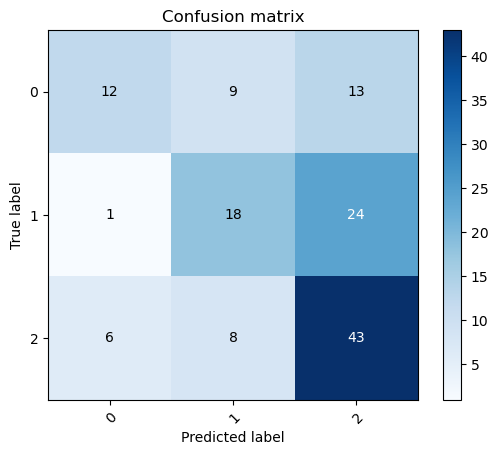

In [47]:
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

In [48]:
# WRITE YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

Accuracy = 0.5447761194029851
Precision (macro average) = 0.5611215538847117
Recall (macro average) = 0.5086439308485532
F1 score (macro average) = 0.5140352921650263
              precision    recall  f1-score   support

           0       0.63      0.35      0.45        34
           1       0.51      0.42      0.46        43
           2       0.54      0.75      0.63        57

    accuracy                           0.54       134
   macro avg       0.56      0.51      0.51       134
weighted avg       0.55      0.54      0.53       134



In [49]:
vocabulary = vectorizer.vocabulary_

### CHANGE THE NAME OF THE CLASSIFIER VARIABLE BELOW TO USE YOUR TRAINED CLASSIFIER
feat_likelihoods = np.exp(classifier.feature_log_prob_)  # Use exponential to convert the logs back to probabilities
###

# WRITE YOUR CODE HERE
#print(feat_likelihoods[:, vocabulary['a']])
#print(feat_likelihoods[:, vocabulary['it']])

# Logistic Regression Classifier



In [50]:


classifier = LogisticRegression()
classifier.fit(X_train, train_labels)

LogisticRegression()

In [51]:
y_val_pred = classifier.predict(X_val)

In [52]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


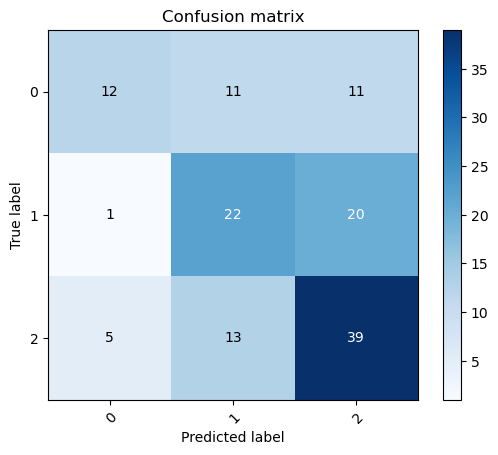

In [53]:

# Define class labels
classes = ['0', '1', '2']

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

## Multi Logistic Regression

In [71]:

classifier = LogisticRegression( multi_class= 'multinomial')
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)

In [72]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)

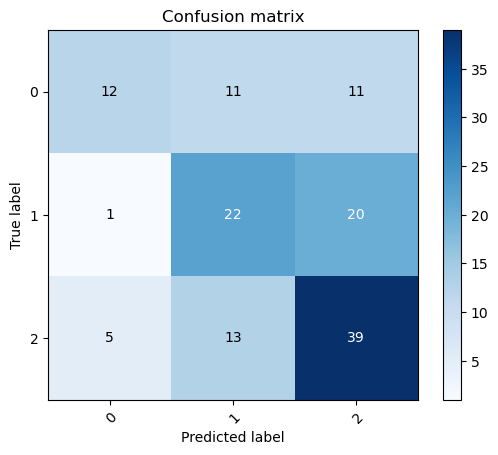

In [73]:

# Define class labels
classes = ['0', '1', '2']

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

## 1.2. Evaluate Method

Evaluate your method, then interpret and discuss your results. Include the following points:
• Define your performance metrics and state their limitations;
• Describe the testing procedure (e.g., how you used each split of the dataset);
• Show your results using suitable plots or tables;
• How could you improve the method or experimental process? Consider the errors that your
method makes.  
(9 marks)


In [57]:
# WRITE YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

Accuracy = 0.5447761194029851
Precision (macro average) = 0.5673567977915804
Recall (macro average) = 0.5162598699210407
F1 score (macro average) = 0.5233645707856094
              precision    recall  f1-score   support

           0       0.67      0.35      0.46        34
           1       0.48      0.51      0.49        43
           2       0.56      0.68      0.61        57

    accuracy                           0.54       134
   macro avg       0.57      0.52      0.52       134
weighted avg       0.56      0.54      0.54       134



# 1.3 Common Themes & Topics

1.3. Can you identify common themes or topics associated with negative sentiment or positive
sentiment in this dataset?
• Explain the method you use to identify themes or topics;
• Show your results (e.g., by listing or visualising example topics or themes);
• Interpret the results and summarise the limitations of your approach.
(12 marks) 

In [58]:
n_feats_to_show = 10

# Flip the index so that values are keys and keys are values:
keys = vectorizer.vocabulary_.values()
values = vectorizer.vocabulary_.keys()
vocab_inverted = dict(zip(keys, values))

for c, weights_c in enumerate(classifier.coef_):
    print(f'\nWeights for class {c}:\n')
    strongest_idxs = np.argsort(weights_c)[-n_feats_to_show:]

    for idx in strongest_idxs:
        print(f'{vocab_inverted[idx]} with weight {weights_c[idx]}')


Weights for class 0:

hit with weight 0.6183600346140179
downside with weight 0.6831145522994894
bhp with weight 0.7208800839239721
drop with weight 0.7251829041979487
bearish with weight 0.8020438060636808
weak with weight 0.8075168453755912
falls with weight 0.8693027123846081
fall with weight 1.0454175096724598
lower with weight 1.2004839464887798
short with weight 1.2470257303321775

Weights for class 1:

cnp with weight 0.5546022992296046
goog with weight 0.5653582448491392
today with weight 0.5764660636634573
barclays with weight 0.5867845378402736
bg with weight 0.6238286664471016
china with weight 0.6349414676397738
shell with weight 0.6407997470619636
uk with weight 0.7877765170570482
sells with weight 0.866385718014921
ceo with weight 0.9181355147593747

Weights for class 2:

higher with weight 0.6851168257783069
line with weight 0.6934591020026657
highs with weight 0.6950541242497945
outperform with weight 0.6997330981041223
rise with weight 0.7431874773986458
breakout with

### Topics

In [59]:
pos_index = all_labels == 2  # compare predictions to gold labels
neg_index = all_labels == 0  # compare predictions to gold labels
# get the text of tweets where the classifier made an error:
pos_tweets = np.array(all_text)[pos_index]
neg_tweets = np.array(all_text)[neg_index]

In [60]:
#type(pos_tweets)
print(pos_tweets[0])
print(neg_tweets[0])

Primark racks up a happy Christmas after strong sales
Royal Mail chairman Donald Brydon set to step down


In [61]:
processed_pos = []
processed_neg = []

In [62]:
from nltk.stem import WordNetLemmatizer 
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS # find stopwords

np.random.seed(400)  # We fix the random seed to ensure we get consistent results when we repeat the lab.

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :  # Tokenize, remove very short and very long words, convert to lower case, remove words containing non-letter characters
        if token not in STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, 'v'))
            
    return result

# Create lists of preprocessed documents
for tweet in pos_tweets:
    processed_pos.append(preprocess(tweet))
    
for tweet in neg_tweets:
    processed_neg.append(preprocess(tweet))

In [63]:
# nltk.download('wordnet')

In [64]:
print(processed_pos[0])
print(processed_neg[0])

['primark', 'rack', 'happy', 'christmas', 'strong', 'sales']
['royal', 'mail', 'chairman', 'donald', 'brydon', 'set', 'step']


In [65]:
from gensim.corpora import Dictionary

dictionary_pos = Dictionary(processed_pos) # construct word<->id mappings - it does it in alphabetical order
print(dictionary_pos)

pos_bow_corpus = [dictionary_pos.doc2bow(tweet) for tweet in processed_pos]

dictionary_neg = Dictionary(processed_neg) # construct word<->id mappings - it does it in alphabetical order
print(dictionary_neg)

neg_bow_corpus = [dictionary_neg.doc2bow(tweet) for tweet in processed_neg]

Dictionary(1633 unique tokens: ['christmas', 'happy', 'primark', 'rack', 'sales']...)
Dictionary(1155 unique tokens: ['brydon', 'chairman', 'donald', 'mail', 'royal']...)


In [66]:
len(pos_bow_corpus)

469

In [67]:
len(neg_bow_corpus)

283

In [68]:
from gensim.models import LdaModel

lda_pos_model =  LdaModel(pos_bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary_pos,                                    
                      passes=10,
                    ) 

lda_neg_model =  LdaModel(neg_bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary_neg,                                    
                      passes=10,
                    ) 

In [69]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_pos_model.print_topics(-1):
    print("Pos Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")
    
for idx, topic in lda_neg_model.print_topics(-1):
    print("Neg Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Pos Topic: 0 
Words: 0.016*"buy" + 0.015*"https" + 0.012*"aapl" + 0.012*"look" + 0.012*"stks" + 0.012*"http" + 0.010*"good" + 0.008*"high" + 0.008*"dividend" + 0.008*"call"


Pos Topic: 1 
Words: 0.015*"price" + 0.015*"share" + 0.014*"day" + 0.010*"higher" + 0.010*"growth" + 0.009*"earn" + 0.008*"climb" + 0.008*"end" + 0.008*"run" + 0.008*"dividend"


Pos Topic: 2 
Words: 0.022*"https" + 0.015*"profit" + 0.014*"buy" + 0.013*"astrazeneca" + 0.011*"look" + 0.011*"tsla" + 0.009*"rise" + 0.008*"break" + 0.008*"continue" + 0.008*"sales"


Pos Topic: 3 
Words: 0.039*"long" + 0.037*"http" + 0.037*"stks" + 0.013*"https" + 0.011*"aapl" + 0.009*"market" + 0.009*"sales" + 0.008*"position" + 0.008*"go" + 0.008*"amzn"


Pos Topic: 4 
Words: 0.011*"higher" + 0.011*"astrazeneca" + 0.011*"https" + 0.010*"ftse" + 0.008*"approval" + 0.008*"support" + 0.006*"tesco" + 0.006*"billion" + 0.006*"steady" + 0.006*"buy"


Pos Topic: 5 
Words: 0.018*"stock" + 0.010*"new" + 0.010*"resistance" + 0.008*"watch" + 0.

### Individual Topic Distribution

In [70]:
test_document_idx = 10
unseen_document = pos_tweets[test_document_idx]
print(unseen_document)

#print(f' This document is from newsgroup {newsgroups_test.target_names[newsgroups_test.target[test_document_idx]]}')

# Data preprocessing step for the unseen document - It is the same preprocessing we have performed for the training data
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for idx, count in bow_vector:
    print(f'{dictionary[idx]}: {count}')

ARM Royalties Accelerate as Smartphone Market Regains Strength


NameError: name 'dictionary' is not defined

In [ ]:
topic_distribution = lda_model[bow_vector]

for index, probability in sorted(topic_distribution, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t Topic: {}".format(index, probability, lda_model.print_topic(index, 5)))

In [ ]:
# make list of tuples ready for model training

train_set = list(zip(list_a, list_b))

## Task 2: Named Entity Recognition (max. 19%)  

In scientific research, information extraction can help researchers to discover relevant findings from
across a wide body of literature. As a first step, your task is to build a tool for named entity
recognition in scientific journal article abstracts. We will be working with the BioNLP 2004 dataset of
abstracts from MEDLINE, a database containing journal articles from fields including medicine and
pharmacy. The data was collected by searching for the terms ‘human’, ‘blood cells’ and
‘transcription factors’, and then annotated with five entity types: DNA, protein, cell type, cell line,
RNA. 

More information can be found in the paper: https://aclanthology.org/W04-1213.pdf .
We provide a cache of the data and code for loading the data in ‘data_loader_demo’ in our Github
repository, https://github.com/uob-TextAnalytics/intro-labs-public. This script downloaded the data
from HuggingFace, where you can also find more information about the dataset:
https://huggingface.co/datasets/tner/bionlp2004 .


The data is presented in this paper:
Nigel Collier, Tomoko Ohta, Yoshimasa Tsuruoka, Yuka Tateisi, and Jin-Dong Kim. 2004. Introduction
to the Bio-entity Recognition Task at JNLPBA. In Proceedings of the International Joint Workshop on
Natural Language Processing in Biomedicine and its Applications (NLPBA/BioNLP), pages 73–78,
Geneva, Switzerland. COLING.